## Path sampling

This notebook contains the code for Qijia's path sampling idea.

First, imports:

In [1]:
import jax
import jax.numpy as jnp
from nn import MLP, train
import numpy as np
import matplotlib.pyplot as plt
import optax 
import scipy
import os
from functools import partial


`batch_size` is the number of paths (that we use each time we update the drift)

`ndims` is the number of dimensions of the problem. Here we work with a TPS example, of a double well in 2D.

In [2]:
# this allows for parallelization with pmap. Not currently used
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(200)

# currently we're just doing an SDE on \mathbb{R}
ndims = 1


We now define a function that generates random paths given a drift term `b` and a noise term `W`:

In [3]:
def sample_sde(b, W, rho, dt, num_steps, key):

    """
    Sample a path of the SDE defined by b, W, and rho.
    b: drift term. A function from R^ndims x R -> R^ndims
    W: noise term
    rho: initial distribution to sample from
    dt: time step size
    num_steps: number of time steps to take along the path
    key: random key for sampling

    Returns:

    array of size [batch_size, num_steps, ndims] containing the sampled paths
    """

    init_key, run_key = jax.random.split(key)
    X_0 = rho(init_key)

    def body(X_and_t, key):
        X, time = X_and_t

        new_X = X + b(X, time) * dt + W(X_0, key) * jnp.sqrt(dt)
        new_time = time + dt
        return ((new_X, new_time), (new_X, new_time))

    keys = jax.random.split(run_key, num_steps-1)
    path, time =  jax.lax.scan(body, (X_0, 0), keys)[1]
    return jnp.concat((X_0[None], path), axis=0), jnp.concat((jnp.zeros(1,), time), axis=0)


## Example of a path in a double well

Here's an example of sampling a path in a double well potential.

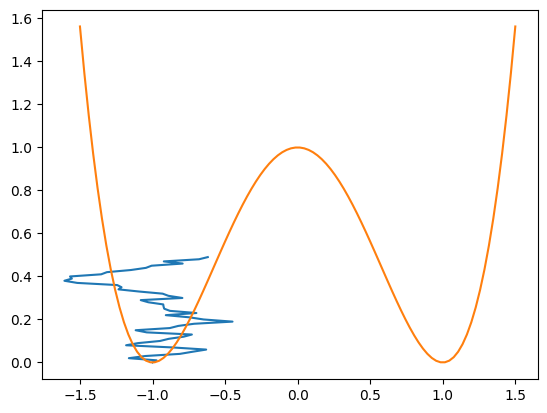

In [4]:
hyperparams={'dt': 0.01, 'num_steps': 50, 'num_training_steps' : 1000}

def make_double_well_potential(v):
    def potential(x):
        """
        Double well potential
        """
        assert x.shape == (ndims,)
        return potential
        # return jnp.sum(v*(x**2 - 1)**2, axis=-1)
    
    return lambda x: jnp.sum(v*(x**2 - 1)**2, axis=-1)

potential = make_double_well_potential(v=1.0)

def uref(x, t): 
    # potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
    return -jax.grad(potential)(x)

path, time = sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=jax.random.key(0), 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps'])

# visualize path
plt.plot(path,time)
# plot potential
# potential = lambda x: jnp.sum(x**4 - 8 * x**2,axis=-1)
x = np.linspace(-1.5, 1.5, 100)

plt.plot(x, make_double_well_potential(v=1.0)(x[:, None]))

In [5]:
# currently set for TPS
def J(x,y):
    """
    x: path of the SDE, array of shape [num_steps, ndims]
    y: observation, here ignored, so assume it's `None`

    Returns:
        a scalar value representing the cost of the path
    """

    sigma = 0.1
    return (1/sigma**2)*(x[-1,0]- 1)**2

# vmap is a jax function that allows us to apply a function to each element of an array
def E_J(J, paths, obs):
    """
    paths: array of shape [batch_size, num_steps, ndims]
    obs: here can just be None
    Returns:
        a scalar value representing the mean cost of the paths
    """
    return jnp.mean(jax.vmap(J)(paths, obs),axis=0)


We can then calculate a path cost `J(x)` as follows:

In [6]:
cost = J(path, None)
print("Cost of path: ", cost)


Cost of path:  262.19205


# Defining h

We now define `h`

In [7]:
def div_f(x,time, f):
    """
    x: path of the SDE, array of shape [num_steps, ndims]
    time: array of shape [num_steps]
    f: a function from R^ndims x R -> R^ndims
    Returns:
        an array of scalar values representing the divergence of f at x[i] and time[i]
    """
    return jax.vmap(lambda xt, t: jnp.trace(jax.jacobian(lambda k: f(k,t))(xt)))(x, time)

def dfdt(x, dt):
    """
    x: path of the SDE, array of shape [num_steps, ndims]
    dt: time step size
    Returns:
        an array of shape [num_steps, ndims] representing the derivative of x with respect to time
    """
    return jnp.concatenate([jnp.zeros((1, x.shape[1])) , x[1:, :] - x[:-1, :]], axis=0)/ dt


In [8]:

def I(x, time, uref):
    x = x.reshape((-1, ndims))
    dt = time[1]
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, uref)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - uref(xt, t)).dot(dxdt - uref(xt, t)) + 0.5*div_u)) (x, time, div_us, dxdts)
    return jnp.sum(out)

def make_h(b, dbds, s):
    """
    b: drift term. A function from R^ndims x R -> R^ndims
    dbds: also a function from R^ndims x R -> R^ndims
    Returns:
        a function h, as defined below
    """

    @jax.jit # this speeds up the function
    def h(x, time):
        """
        x: path of the SDE, array of shape [num_steps, ndims]
        time: array of shape [num_steps]
        Returns:
            a scalar value representing the cost of the path
        """
        dt = time[1]

        # a crude approximation of the derivative
        dxdts = dfdt(x, dt)

        # calculate divergence of dbds at all times, using the trace of the jacobian
        # div_dbdss = jax.vmap(lambda xt, t: jnp.trace(jax.jacobian(lambda k: dbds(k,t))(xt)))(x, time)
        div_dbdss = div_f(x,time,partial(dbds, s=s))

        # the discretized integral
        out = jax.vmap(lambda x, t, dxdt, div_dbds: 
                    
                    -0.5*dt*((b(x,t) - dxdt).dot(dbds(x,t, s)) + 0.5*div_dbds)
                    )(x,time, dxdts, div_dbdss)
        
        return jnp.sum(out) 

    return h

# compute the loss function, which here is the square of the difference between the left and right of (7)
def make_h_loss(expectation_of_J, J, b, s):
    """
    expectation_of_J: the expectation of J, computed from the paths
    b: drift term. A function from R^ndims x R -> R^ndims
    Returns:
        a function h_loss, which computes the loss
    """
    
    def h_loss(dbds, xs, times, ys):
        """
        xs: array of shape [batch_size, num_steps, ndims]
        times: array of shape [batch_size, num_steps]
        ys: for current purposes, just None
        Returns:
            a scalar value representing the loss
        """

        h = make_h(b, dbds, s)

        expectation_of_h = jnp.mean(jax.vmap(h)(xs, times), axis=0)

        return jnp.sum(jax.vmap(lambda x,y, t: (-J(x, y)+expectation_of_J - h(x,t) + expectation_of_h)**2)(xs, ys, times))

    return h_loss        


In [9]:
import blackjax

def run_mclmc(logdensity_fn, num_steps, initial_position, key, transform, desired_energy_variance= 5e-4):
    init_key, tune_key, run_key = jax.random.split(key, 3)

    # create an initial state for the sampler
    initial_state = blackjax.mcmc.mclmc.init(
        position=initial_position, logdensity_fn=logdensity_fn, rng_key=init_key
    )

    # build the kernel
    kernel = lambda inverse_mass_matrix : blackjax.mcmc.mclmc.build_kernel(
        logdensity_fn=logdensity_fn,
        integrator=blackjax.mcmc.integrators.isokinetic_mclachlan,
        inverse_mass_matrix=inverse_mass_matrix,
    )

    # find values for L and step_size
    (
        blackjax_state_after_tuning,
        blackjax_mclmc_sampler_params,
        _
    ) = blackjax.mclmc_find_L_and_step_size(
        mclmc_kernel=kernel,
        num_steps=num_steps,
        state=initial_state,
        rng_key=tune_key,
        diagonal_preconditioning=False,
        desired_energy_var=desired_energy_variance
    )

    # use the quick wrapper to build a new kernel with the tuned parameters
    sampling_alg = blackjax.mclmc(
        logdensity_fn,
        L=blackjax_mclmc_sampler_params.L,
        step_size=blackjax_mclmc_sampler_params.step_size,
    )

    # run the sampler
    _, samples = blackjax.util.run_inference_algorithm(
        rng_key=run_key,
        initial_state=blackjax_state_after_tuning,
        inference_algorithm=sampling_alg,
        num_steps=num_steps,
        transform=transform,
        progress_bar=False,
    )

    return samples, blackjax_state_after_tuning, blackjax_mclmc_sampler_params, run_key


def refine_path(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)- I(x, time, lambda x, t: uref(-x,t)) - s*J(x.reshape((-1, ndims)), None)
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)- I(x, time, lambda x, t: uref(x,t)) - s*J(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]

In [15]:
import itertools


def find_dbds(dbds, J, s, b, xs, times, ys, num_training_steps):
    """
    model_key: random key for the model
    expectation_of_J: the expectation of J, computed from the paths
    b: drift term. A function from R^ndims x R -> R^ndims
    xs: array of shape [batch_size, num_steps, ndims]
    times: array of shape [batch_size, num_steps]
    ys: for current purposes, just None
    num_training_steps: number of training steps to take
    Returns:
        dbds: the trained model, which is a function from R^ndims x R -> R^ndims
    """

    expectation_of_J = E_J(J, xs, ys)

    print(s, "s")

    # dbds = MLP([3,20,20,1], key=model_key) # create an NN, with random weights
    learning_rate = 1e-3
    optimizer = optax.adam(learning_rate)
    h_loss = make_h_loss(expectation_of_J, J, b, s)
    dbds = train(h_loss, dbds, optimizer, num_training_steps, xs, times, ys)
    return dbds

def make_b(schedule, uref, dbds):

    schedule_padded = np.concatenate([np.zeros((1,)), np.array(schedule)])

    # dss = np.concatenate([np.array([schedule[0]]), np.array(schedule)[1:] - np.array(schedule)[:-1]])
    dss = np.array(schedule_padded)[1:] - np.array(schedule_padded)[:-1]

    print(dss)


    print(list(zip(schedule, dss)), "schedule")

    b = lambda x, t: (uref(x,t) + sum([ds*dbds(x,t,s) for (s,ds) in zip(schedule, dss)]))

    return b 

# b \mapsto b + dbds
# Pseudo code:
# create `xs` of shape [batch_size, num_steps, ndims]
# calculate expectation of J
# initialize a neural net as function from R^ndims x R -> R^ndims
# fit weights of neural net according to the loss function
# calculate test loss
# return lambda x: b(x) + dbds(x)
def update(b, J, dbds, hyperparams, key, schedule, i, rho = lambda key: jnp.zeros((ndims,))-1.):
    """
    b: drift term. A function from R^ndims x R -> R^ndims
    hyperparams: dictionary of hyperparameters
    key: random key for the model
    i: index for the current iteration (just for labelling plots)
    Returns:
        new_b: the updated drift term, which is a function from R^ndims x R -> R^ndims
    """

    new_s = schedule[i]
    old_s = schedule[i-1] if i>0 else 0.0
    ds = new_s - old_s

    # b = make_b(schedule[:i], uref, dbds)

    path_key, model_key, refine_key = jax.random.split(key, 3)

    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,))
    

    # xs : [batch_size, num_steps, ndims]
    xs, times = jax.pmap(lambda key:sample_sde(
    b=b, 
    W = W,
    rho = rho,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, hyperparams['batch_size']))

    time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']
    
    print("old s", old_s)

    # path refinement
    # new_xs = jax.pmap(lambda key, p: refine_path(
    # x=p,
    # s=old_s,
    # time=time,
    # rng_key=key,
    # num_steps=1000
    # ))(jax.random.split(refine_key, hyperparams['batch_size']), xs)[:,:, None]

    # print(E_J(xs, None), "ej x")
    # print(E_J(new_xs, None), "ej new x")
    # print(times)

    # for path in xs:
    #     plt.plot(path,(time/hyperparams['dt'])/10, label='old')
    # for path in new_xs:
    #     plt.plot(path,(time/hyperparams['dt'])/5, label=f'annealed')

    # xs = jnp.concatenate((xs[:10, :, :], new_xs[:30, :, :]), axis=0)
    # xs = new_xs

    expectation_of_J = E_J(J, xs, None)

    dbds = find_dbds(
        dbds=dbds,
        J=J,
        s=new_s,
        b=b,
        # xs[:90, :, :],
        # times[:90, :],
        xs=xs,
        times=times,
        ys=None,
        num_training_steps=hyperparams['num_training_steps']
        )
    
    ### calculate test loss
    test_xs, test_times = jax.pmap(lambda key:sample_sde(
        b=b, 
        W = W,
        rho = rho,
        key=key, 
        dt=hyperparams['dt'], 
        num_steps=hyperparams['num_steps']))(jax.random.split(jax.random.key(500), hyperparams['batch_size']))

    print(f"Test loss is {make_h_loss(expectation_of_J=expectation_of_J, J=J, b=b, s=new_s)(dbds, test_xs, test_times, None)}")

    # new version
    # new+b = b + [dbds(x,t,s)*delta_s for s in ...]

    # print(ds, "ds")
    
    new_b =  lambda x, t: (b(x,t) + dbds(x,t, 0.0)*ds)

    # new_b =  lambda x, t: (b(x,t) + dbds(x,t, new_s))

    # new_b = make_b(schedule[:i+1], uref, dbds)

    plot = True
    if plot:

        x = jnp.expand_dims(jnp.linspace(-5, 5, 100), 1)
        # y = (x**4 - 8 * x**2)
        y = make_double_well_potential(v=5.0)(x)
        y2 = jax.vmap(lambda k, t: new_b(k, t))(x, times[0])
        plt.ylim(-15,15)
        if i==0: plt.plot(x, y)
        plt.plot(x, y2/500)
        # print(y2)

        path, time = sample_sde(
            b=new_b, 
            W = W,
            rho = rho,
            key=key, 
            dt=hyperparams['dt'], 
            num_steps=hyperparams['num_steps'])
                
        refined_path = refine_path(
            x=path,
            s=new_s,
            time=time,
            rng_key=jax.random.key(2),
            num_steps=1000
            )
        

        print("OM of path", I(path, time, uref))
        print("OM of refined path", I(refined_path, time, uref))

        plt.plot(path,(time/hyperparams['dt'])/10, label=i)
        plt.plot(refined_path,(time/hyperparams['dt'])/10, label=f'refined_{i}')
        # plt.savefig('potential_new.png')
        plt.legend()

    return new_b


In [16]:
key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.2,0.4,0.6,0.8,1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))


b = uref
for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    b = update(
        b=b, # lambda x, t : jnp.array([0.0]),
        J=J,
        dbds=dbds,
        hyperparams={'dt': 0.001, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :100},
        key=key,
        schedule=schedule,
        i=i,
    )

# potential(jnp.array([0.0]))

# jax.grad(lambda x:jnp.sum(x**2))(jnp.array([4.0]))
# uref(jnp.array([0.0]), 0.0)

old s 0.0
0.2 s
Train loss: 104613.6015625
Test loss is 115432.328125
[0.2]
[(0.2, np.float64(0.2))] schedule
OM of path 84.1376
OM of refined path 54.154297
old s 0.2
0.4 s


[]
[] schedule
old s 0.0
0.2 s
Train loss: 15542099.0
Test loss is 13061656.0
[0.2]
[(0.2, np.float64(0.2))] schedule
OM of path 2127.2332
OM of refined path 64.579185
[0.2]
[(0.2, np.float64(0.2))] schedule
old s 0.2
0.4 s
Train loss: 5289593.5
Test loss is 5276291.5
[0.2 0.2]
[(0.2, np.float64(0.2)), (0.4, np.float64(0.2))] schedule
OM of path 361.5604
OM of refined path 57.89183
[0.2 0.2]
[(0.2, np.float64(0.2)), (0.4, np.float64(0.2))] schedule
old s 0.4
0.6 s
Train loss: 2120694.25
Test loss is 1789538.625
[0.2 0.2 0.2]
[(0.2, np.float64(0.2)), (0.4, np.float64(0.2)), (0.6, np.float64(0.19999999999999996))] schedule
OM of path 49.02902
OM of refined path 53.28998
[0.2 0.2 0.2]
[(0.2, np.float64(0.2)), (0.4, np.float64(0.2)), (0.6, np.float64(0.19999999999999996))] schedule
old s 0.6
0.8 s
Train loss: 336332.21875
Test loss is 610209.125
[0.2 0.2 0.2 0.2]
[(0.2, np.float64(0.2)), (0.4, np.float64(0.2)), (0.6, np.float64(0.19999999999999996)), (0.8, np.float64(0.20000000000000007))]

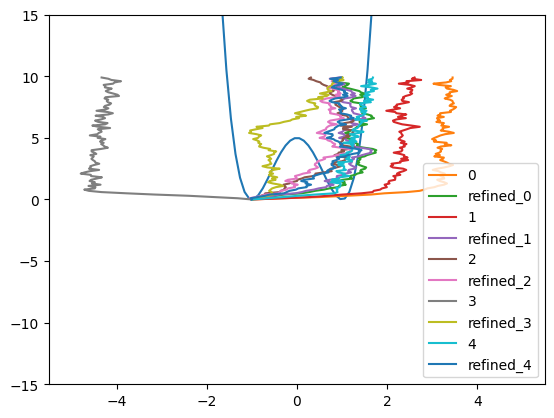

In [28]:
key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.2, 0.4, 0.6, 0.8, 1.0] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))


for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    dbds = update(
        uref=uref,
        J=J, 
        dbds=dbds,
        hyperparams={'dt': 0.005, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :100},
        key=key,
        schedule=schedule,
        i=i,
    )
    

[]
[] schedule
old s 0.0
x (100,)
(100,) laplace shape
x (100,)
(100,) laplace shape
0.1 s
x (100,)
(100,) laplace shape
Train loss: 13749228.0
x (100,)
(100,) laplace shape
Test loss is 25957872.0
[0.1]
[(0.1, np.float64(0.1))] schedule
OM of path 106.10812
OM of refined path 84.69473
[0.1]
[(0.1, np.float64(0.1))] schedule
old s 0.1
x (100,)
(100,) laplace shape
x (100,)
(100,) laplace shape
0.2 s
x (100,)
(100,) laplace shape
Train loss: 243765.34375
x (100,)
(100,) laplace shape
Test loss is 195891.9375
[0.1 0.1]
[(0.1, np.float64(0.1)), (0.2, np.float64(0.1))] schedule
OM of path 103.3293
OM of refined path 98.068756


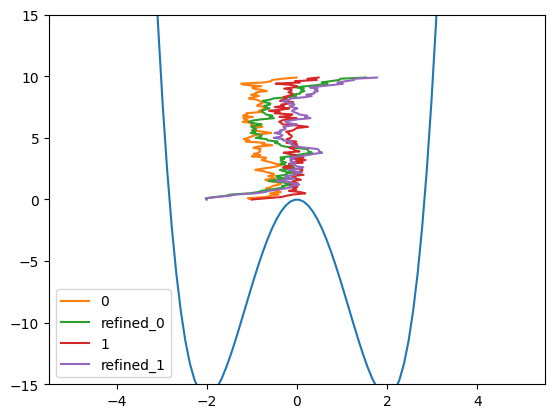

In [213]:
key = jax.random.key(0)
# b = uref # initialize b as uref
schedule = [0.1, 0.2] # , 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
dbds = MLP([3,20,20,1], key=jax.random.key(0))

hyperparams = {'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000, 'batch_size' :100}

brownian_bridge_drift = lambda x,t: (1 - x)/(1-t)

potential = lambda x: jnp.sum(x**4 - 8 * x**2)
force = jax.grad(lambda x: -jnp.sum(x**4 - 8 * x**2))

 

def J_brownian_bridge(x, y):
    x = x[:, 0]
    print("x", x.shape)

    eps = 1. # hyperparams['dt']
    laplacian_of_force = jax.vmap(lambda xt: jax.grad(force)(xt))(x)
    print(laplacian_of_force.shape, "laplace shape")
    # jax.debug.print("force x0 {x}", x=force(x[0]))
    return (1/(2*eps**2))*jnp.sum(jax.vmap(lambda xt, dv :  0.5*eps*(force(xt).dot(force(xt)) - eps*dv) )(x, laplacian_of_force))
                                                                                #   ))(x, dVs))

for i, s in enumerate(schedule):



    key = jax.random.fold_in(key, i)

    # update b -> b + dbds
    dbds = update(
        uref=brownian_bridge_drift,
        J=J_brownian_bridge, 
        dbds=dbds,
        hyperparams=hyperparams,
        key=key,
        schedule=schedule,
        i=i,
        rho = lambda key: jnp.zeros((ndims,))-1.
    )

## Everything below here is a work in progress, ignore for now!

In [110]:
# def new_b(x, t): 
#     # assert x.shape[0] == ndims
#     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

hyperparams={'dt': 0.001, 'num_steps': 200, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


path_key = jax.random.key(1)
xs, times = jax.pmap(lambda key:sample_sde(
    b=uref, 
    W = lambda _, key: jnp.sqrt(2)*jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-2.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


def I_exp(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, b)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - b(xt, t)).dot(dxdt - b(xt, t)) + 0.5*div_u) )(x, time, div_us, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)


# use mcmc with the onsager machlup functional to correct samples

def refine_path_exp(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, uref) - s*J(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]




samples = refine_path_exp(
    x=xs[0],
    s=0.0,
    time=time,
    rng_key=jax.random.key(0),
    num_steps=100000
)



0.001
0.001
0.001
0.001
0.001
0.001
0.001


(200,)


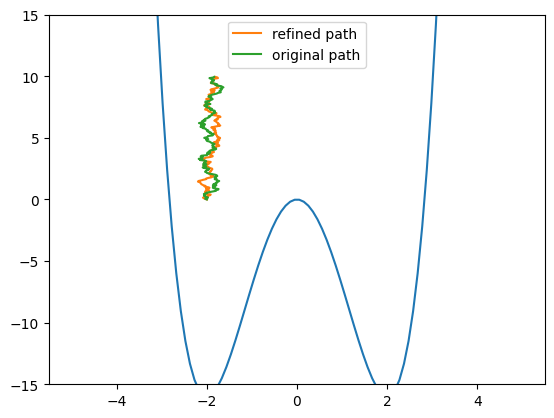

In [111]:
# plot samples[-1]
print(samples.shape)
# plt.plot(samples[0, :])
# hyperparams['dt']

# (time/hyperparams['dt']) / 5
# time

x = jnp.expand_dims(jnp.linspace(-5, 5, 100), 1)
y = (x**4 - 8 * x**2)
plt.ylim(-15,15)
plt.plot(x, y)
plt.plot(samples[:],(time/hyperparams['dt'])/20, label='refined path')
plt.plot(xs[0],(time/hyperparams['dt'])/20, label='original path')
plt.legend()

In [40]:
I_exp(samples, time, uref)
# samples.shape

0.001


Array(116.70465, dtype=float32)

## Brownian sanity check

In [50]:
# def new_b(x, t): 
#     # assert x.shape[0] == ndims
#     return -jax.grad(lambda x: (x**4 - 8 * x**2))(x)

hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


path_key = jax.random.key(0)
xs_true, times = jax.pmap(lambda key:sample_sde(
    b=lambda x,t: (1- x)/(1-t),
    W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 100))

xs, times = jax.pmap(lambda key:sample_sde(
    b=lambda x,t: 0.0,
    W = lambda _, key: jax.random.normal(key, shape=(ndims,)),
    # rho = lambda key: jax.random.normal(key, shape=(ndims,))-2,
    rho = lambda key: jnp.zeros((ndims,))-1.,
    key=key, 
    dt=hyperparams['dt'], 
    num_steps=hyperparams['num_steps']))(jax.random.split(path_key, 1))


def J_exp(x,y):
    """
    x: path of the SDE, array of shape [num_steps, ndims]
    y: observation, here ignored, so assume it's `None`

    Returns:
        a scalar value representing the cost of the path
    """

    sigma = 0.1
    return (1/sigma**2)*(x[-1,0]- 1)**2

def I_exp(x, time, b):
    x = x.reshape((-1, ndims))
    dt = hyperparams['dt']
    print(dt)
    dxdts = dfdt(x, dt)
    div_us = div_f(x, time, b)
    out = jax.vmap(lambda xt,t, div_u, dxdt : 0.5*dt*(0.5*(dxdt - b(xt, t)).dot(dxdt - b(xt, t)) + 0.5*div_u) )(x, time, div_us, dxdts)
    # div = jax.vmap(lambda xt,t, div_u, dxdt : div_u)(x, time, div_us, dxdts)
    # jax.debug.print("div {x}", x=jnp.sum(div))
    return jnp.sum(out)


# use mcmc with the onsager machlup functional to correct samples

def refine_path_exp(x, s, time, rng_key, num_steps):
    initial_position = x.reshape(x.shape[0]*x.shape[1])

    # logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-2, scale=0.01)-I_exp(x, time, lambda k, t: uref(k,t)) 
    logdensity_fn = lambda x: jax.scipy.stats.norm.logpdf(x[0], loc=-1, scale=0.01)-I_exp(x, time, uref) - s*J_exp(x.reshape((-1, ndims)), None)

    # logdensity_fn = lambda x: I(x, time, uref) 

    samples, _, params, chain_key = run_mclmc(
        logdensity_fn=logdensity_fn,
        num_steps=num_steps,
        initial_position=initial_position,
        key=rng_key,
        transform=lambda state, info: state.position
    )

    return samples[-1]




samples = refine_path_exp(
    x=xs[0],
    s=1.0,
    time=time,
    rng_key=jax.random.key(0),
    num_steps=10000
)

0.01
0.01
0.01
0.01
0.01
0.01
0.01


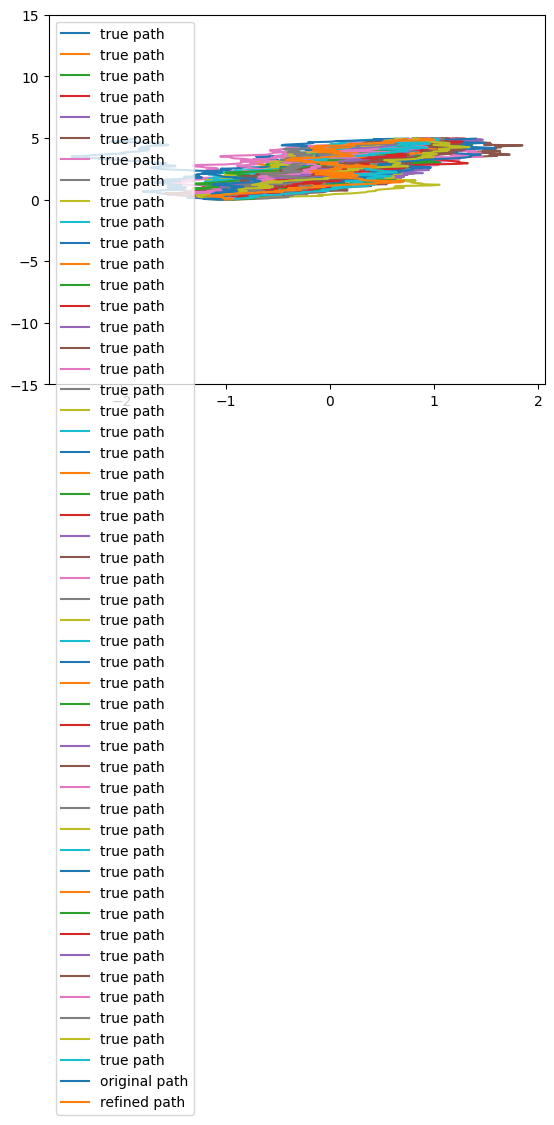

In [51]:

plt.ylim(-15,15)
for i in range(50):
    plt.plot(xs_true[i,:,0],(time/hyperparams['dt'])/20, label='true path')
plt.plot(xs[0,:,0],(time/hyperparams['dt'])/20, label='original path')
plt.plot(samples,(time/hyperparams['dt'])/20, label='refined path')

plt.legend()

# xs

## SPDE approach

In [228]:
hyperparams={'dt': 0.01, 'num_steps': 100, 'num_training_steps' : 1000}

time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']


force = jax.grad(lambda x: -jnp.sum(x**4 - 8 * x**2))


def numerical_laplacian(arr, dt):

    arr = jnp.concatenate([jnp.array([arr[0]]), arr, jnp.array([arr[-1]])])
    fst_diff = (arr[1:] - arr[:-1])
    snd_diff = (fst_diff[1:] - fst_diff[:-1])
    jax.debug.print("snd_diff {x}", x=snd_diff)
    return snd_diff

def spde_integrator(x, force, sigma=1, num_steps=10):
    ds = 0.01


    def step(x):

        # second_difference = (first_difference[:-1] - ) / hyperparams['dt']
        laplace_t_x = numerical_laplacian(x, dt=hyperparams['dt'])
        term2 = -jax.vmap(force)(x)*jax.vmap(jax.grad(force))(x)
        term3 = -(sigma**2)*jax.vmap(jax.grad(jax.grad(force)))(x)
        noise = jnp.sqrt(2)*jax.random.normal(key, shape=x.shape)

        return x + ds*(1/(sigma**2))*(laplace_t_x + term2 + term3) + jnp.sqrt(ds)*noise
    
    for i in range(num_steps):
        x = step(x)
        # print(x.shape)

    return x

# spde_integrator(
#     x=jnp.array([1.,2.,1.,4.,5.,1.,1.]),
#     force=force,
#     ).shape



initial = jnp.linspace(-1,1, 100)
# initial


snd_diff [ 2.0202041e-02  0.0000000e+00 -1.1920929e-07  1.1920929e-07
  0.0000000e+00  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -1.1920929e-07  1.1920929e-07  0.0000000e+00
  0.0000000e+00  0.0000000e+00 -1.1920929e-07  1.1920929e-07
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.1920929e-07
  2.3841858e-07 -2.3841858e-07  1.1920929e-07  0.0000000e+00
 -8.9406967e-08  1.4901161e-07 -1.1920929e-07  2.9802322e-08
  2.9802322e-08  0.0000000e+00 -2.9802322e-08 -2.9802322e-08
  1.1920929e-07 -1.4901161e-07  8.9406967e-08  0.0000000e+00
 -8.9406967e-08  1.4901161e-07 -1.1920929e-07  2.9802322e-08
  2.9802322e-08  0.0000000e+00 -2.9802322e-08 -2.9802322e-08
  1.1920929e-07 -1.4901161e-07  8.9406967e-08  0.0000000e+00
 -8.9406967e-08  5.9604645e-08  2.9802322e-08  0.0000000e+00
  0.0000000e+00  0.0000000e+00  0.0000000e+00 -1.1920929e-07
  1.1920929e-07  0.0000000e+00  0.0000000e+00  0.0000000e+00
  0.0000000e+00 -1.1920929e-07  1.1920929e-07  0.0000000e+00
  0.0000000e+00

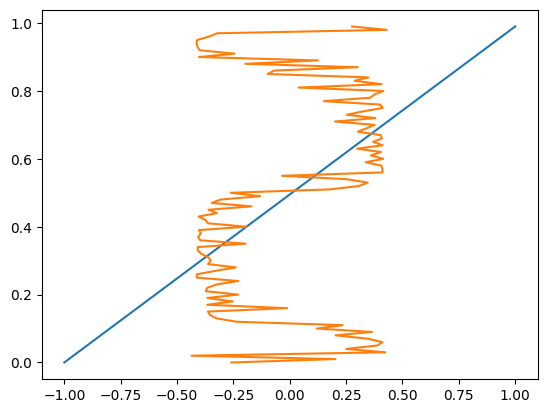

In [229]:
# plot initial
time = np.arange(0,hyperparams['num_steps'])*hyperparams['dt']
plt.plot(initial, time, label='initial')
x = spde_integrator(
    x=jnp.array(initial),
    force=force,
    )
# initial.shape
plt.plot(x, time, label='integrated')

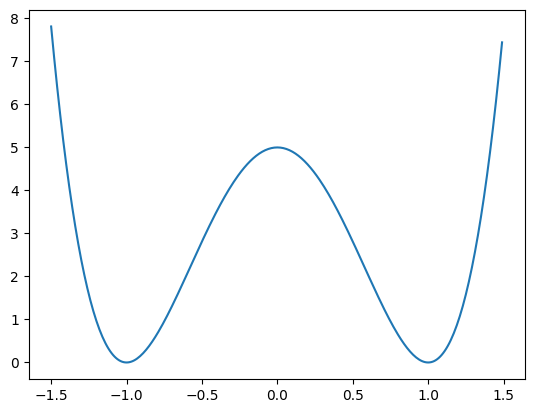

In [242]:
# plot (x^2 - 1)^2
inp = jnp.arange(start=-1.5, stop=1.5, step=0.01)
# inp
plt.plot(inp, 5*(inp**2 - 1)**2, label='potential')